<a href="https://colab.research.google.com/github/LeeSeungwon89/Machine-learning_Theory/blob/master/CHAPTER6%20%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98%20%EC%B2%B4%EC%9D%B8%EA%B3%BC%20%ED%8C%8C%EC%9D%B4%ED%94%84%EB%9D%BC%EC%9D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 들어가며

4장에서 살폈듯이 입력 데이터의 표현 형태에 민감한 머신러닝 알고리즘이 많습니다. 직접 데이터의 스케일을 조정하고 특성을 연결하는 것부터 시작해서 3장에서처럼 비지도 학습으로 특성을 만들기도 합니다. 따라서 대부분의 머신러닝 애플리케이션은 알고리즘 하나로 구성되지 않습니다. 여러 단계의 처리 과정과 머신러닝 모델이 연결되어 있습니다.

이번 장에서는 데이터 변환 과정과 머신러닝 모델을 쉽게 연결해주는 `Pipeline` 클래스를 설명합니다. 특히 `Pipeline`과 `GridSearchCV`를 함께 사용해서 각 처리 단계에서 필요한 매개변수 탐색을 동시에 수행하겠습니다.

모델 체인의 좋은 예로 3장에서 cancer 데이터셋을 `MinMaxScaler`로 전처리를 해서 커널 SVM의 성능을 향상시켰었습니다. cancer 데이터셋의 스케일을 조정하고 `SVC(C=100)` 모델을 사용해서 테스트 세트 정확도를 63% -> 97%만큼 개선했습니다.

다음은 데이터를 분할하고 최솟값, 최댓값을 찾아서 데이터의 스케일을 바꾸고 SVM을 훈련시키는 코드입니다.

In [48]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터를 적재하고 분할합니다.
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)
# 훈련 데이터의 최솟값, 최댓값을 계산합니다.
scaler = MinMaxScaler().fit(X_train)
# 훈련 데이터의 스케일을 조정합니다.
X_train_scaled = scaler.transform(X_train)
# 스케일이 조정된 훈련 데이터에 SVM을 학습시킵니다.
svm = SVC()
svm.fit(X_train_scaled, y_train)
# 테스트 데이터의 스케일을 조정하고 점수를 계산합니다.
X_test_scaled = scaler.transform(X_test)
print('테스트 점수: {:.2f}'.format(svm.score(X_test_scaled, y_test)))

테스트 점수: 0.97


# **6.1 데이터 전처리와 매개변수 선택**

5장에서처럼 `GridSearchCV`를 사용해서 더 좋은 SVC 매개변수를 찾고자 합니다. 단순한 방법을 코드로 구현합니다. 실제로 사용해서는 안 됩니다.

In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid)
grid.fit(X_train_scaled, y_train)
print('최상의 교차 검증 정확도: {:.2f}'.format(grid.best_score_))
print('테스트 점수: {:.2f}'.format(grid.score(X_test_scaled, y_test)))
print('최적 매개변수', grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 점수: 0.97
최적 매개변수 {'C': 1, 'gamma': 1}


스케일을 조정한 데이터를 사용해서 SVC의 매개변수에 대해 그리드 서치를 수행했습니다. 그러나 이 코드에는 교묘한 함정이 있습니다. 데이터의 최솟값과 최댓값을 계산할 때 학습을 위해 훈련 세트에 있는 모든 데이터를 사용했습니다. 그런 다음에 스케일이 조정된 훈련 데이터에서 교차 검증을 사용해서 그리드 서치를 수행했습니다. 교차 검증의 각 분할에서 원본 훈련 세트 데이터의 어떤 부분은 훈련 폴드가 되고 어떤 부분은 검증 폴드가 됩니다. 검증 폴드는 훈련 폴드로 학습된 모델이 새로운 데이터에 적용될 때의 성능을 측정하는 데 사용합니다. 그러나 데이터 스케일을 조정할 때 검증 폴드에 들어 있는 정보까지 전부 사용했습니다. 다시 말하면 교차 검증의 반복마다 선택된 검증 폴드는 전체 훈련 세트의 일부이고, 우리는 데이터의 스케일을 조정하고자 전체 훈련 세트를 이용했습니다. 하지만 이는 새로운 데이터가 모델에 나타날 때와 완전히 다릅니다. 새로운 데이터가 관측되면 이 데이터는 훈련 데이터의 스케일 조정에 사용되지 않은 것이므로 최솟값과 최댓값이 훈련 데이터와 다를 수 있습니다.

교차 검증이 수행되는 동안 데이터 처리와 최종 평가가 어떻게 다른지 설명하는 그림을 출력합니다.

In [50]:
pip install mglearn

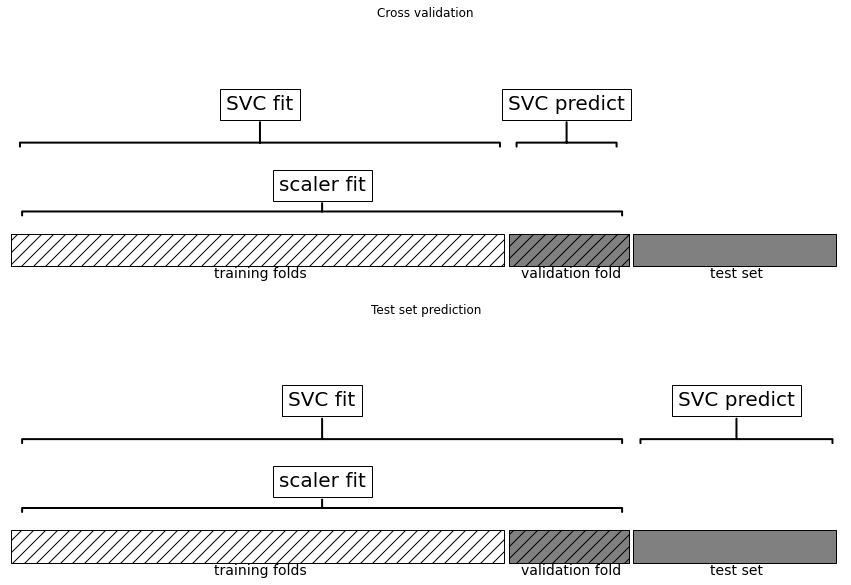

In [51]:
import mglearn

mglearn.plots.plot_improper_processing()

교차 검증 반복 밖에서 전처리가 될 때의 데이터 사용 형태를 나타내는 그림입니다. 상단 그림은 매개변수 선택을 할 때 교차 검증에서 `scaler.fit`과 `SVC.predict`가 모두 검증 폴드를 사용합니다. 하지만 하단 그림은 모델 성능을 평가할 때 `scaler.fit`이 테스트 세트에 적용되지 않습니다.

교차 검증의 분할 방식은 모델이 새 데이터를 만났을 때를 올바로 반영하지 못합니다. 검증 폴드 데이터의 정보가 모델 구축 과정에 이미 알려졌으므로 교차 검증에서 최적의 매개변수를 찾지 못하고 낙관적인 결과를 도출합니다.

이 문제를 해결하려면 모든 전처리 과정보다 교차 검증의 분할이 먼저 이뤄져야 합니다. 데이터셋의 정보를 이용하는 모든 처리 과정은 데이터셋의 훈련 부분에만 적용되어야 하므로 교차 검증 반복 안에 있어야 합니다.

`cross_val_score` 함수와 `GridSearchCV` 함수를 `Pipeline`을 사용하여 위 설명에서 제시한 방법을 구현할 수 있습니다. `Pipeline`은 여러 처리 단계를 하나의 추정기 형태로 묶는 클래스입니다(`BaseEstimator` 클래스를 상속합니다). 아울러 `fit`, `predict`, `score` 메서드를 제공하고, 다른 모델들과 유사하게 작동합니다. `Pipeline`을 사용하는 가장 일반적인 경우는 분류기 같은 지도 학습 모델과 데이터 스케일 조정 같은 전처리 단계를 연결하는 것입니다.

# **6.2 파이프라인 구축하기**

`Pipeline`을 사용해서 `MinMaxScaler`로 데이터 스케일을 조정하고 SVM 모델을 훈련하는 워크플로(workflow)를 표현하는 방식을 알아봅니다.

먼저 각 단계를 리스트로 전달해서 파이프라인 객체를 만듭니다. 각 단계는 추정기의 객체와 임의의 이름(밑줄 문자(_)는 사용 불가능)으로 구성된 튜플(tuple)입니다. 여기서 튜플은 리스트와는 달리 원소를 추가하거나 삭제, 변경할 수 없고 소괄호 형태로 구성됩니다.

In [52]:
from sklearn.pipeline import Pipeline

# 튜플 형태로 구성하여 객체로 넘깁니다.
pipe = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC())])

두 단계를 생성했습니다. 첫 번째 단계와 두 번째 단계를 차례대로 지정한 것입니다. 

다른 예측 모델처럼 파이프라인으로 `fit` 메서드를 호출합니다.

In [53]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svm',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

`pipe.fit`은 첫 번째 단계인 'scaler'의 `fit` 메서드를 호출해서 훈련 데이터를 변환하고, 마지막으로 변환된 데이터에 SVM 모델을 훈련합니다.

테스트 세트로 평가하려면 `pipe.score`를 호출합니다.

In [54]:
print('테스트 점수: {:.2f}'.format(pipe.score(X_test, y_test)))

테스트 점수: 0.97


파이프라인에서 `score` 메서드를 호출하면 먼저 'scaler'를 사용해서 테스트 데이터를 변환하고, 변환된 데이터에 SVM 모델의 `score` 메서드를 호출합니다. 결괏값은 이 파트의 처음 부분에 직접 변환한 코드의 결괏값과 같습니다.

파이프라인을 사용하면 전처리하고 분류하는 과정을 나타내는 코드의 길이가 줄어듭니다. 무엇보다도 더 큰 장점은 `cross_val_score`와 `GridSearchCV`에 파이프라인을 하나의 추정기처럼 사용할 수 있는 것입니다.

# **6.3 그리드 서치에 파이프라인 적용하기**

그리드 서치에 파이프라인을 사용하는 방식도 다른 추정기를 사용하는 방식과 동일합니다. 탐색할 매개변수 그리드를 정의하고, 이 매개변수 그리드와 파이프라인으로 `GridSearchCV`의 객체를 생성합니다. 조금 달라지는 부분이 있다면 각 매개변수가 파이프라인의 어떤 단계에 속한 것인지 지정해야 합니다. `C` 매개변수와 `gamma` 매개변수는 두 번째 단계인 SVC의 매개변수입니다. 앞에서 이 단계의 이름을 'svm'으로 지정했습니다. 파이프라인용 매개변수 그리드는 단계 이름과 매개변수 이름을 밑줄 2개로 연결해서 생성합니다. 따라서 SVC의 매개변수를 그리드 서치로 탐색하려면 매개변수 그리드 딕셔너리의 키를 'svm__C'와 'svm__gamma'로 지정해야 합니다.

In [55]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

이 매개변수 그리드로 `GridSearchCV`를 그대로 사용할 수 있습니다.

In [56]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print('최상의 교차 검증 정확도: {:.2f}'.format(grid.best_score_))
print('테스트 세트 점수: {:.2f}'.format(grid.score(X_test, y_test)))
print('최적 매개변수', grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 세트 점수: 0.97
최적 매개변수 {'svm__C': 1, 'svm__gamma': 1}


이전 그리드 서치와의 차이점은 교차 검증의 각 분할에 `MinMaxScaler`가 훈련 폴드에 매번 적용되어 매개변수 검색 과정에 검증 폴드의 정보가 누설되지 않은 것입니다. 

위 설명에 대하여 앞전에 출력했던 그림과 비교하여 설명하기 위해 두 그림을 출력합니다.

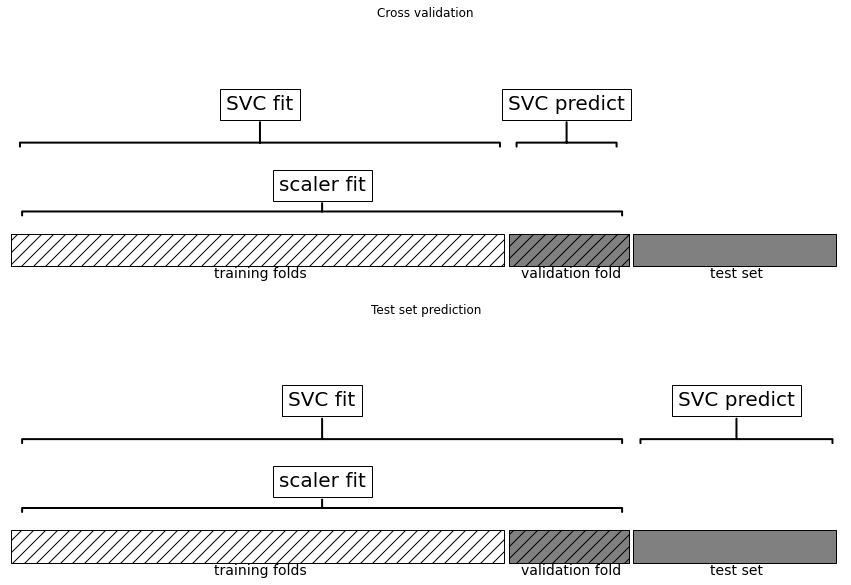

In [57]:
mglearn.plots.plot_improper_processing()

앞전에 출력했던 그림입니다. 교차 검증 반복 밖에서 전처리가 될 때 데이터가 사용되는 형태를 나타냅니다.

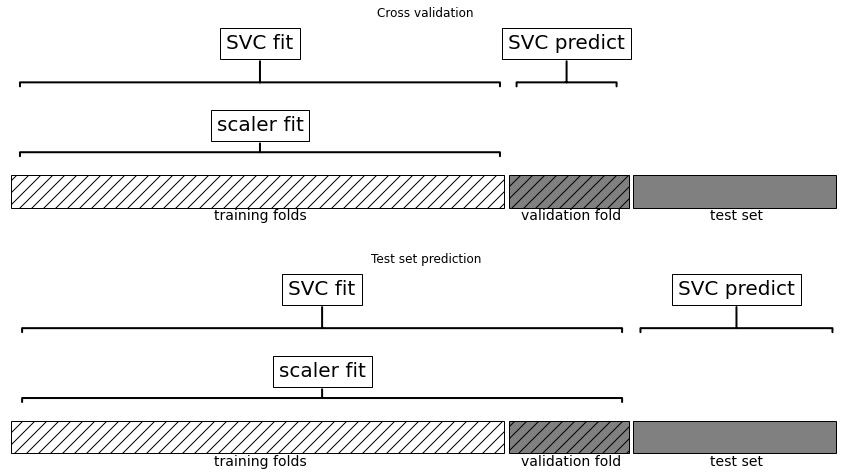

In [58]:
mglearn.plots.plot_proper_processing()

교차 검증 반복 안에서 전처리가 될 때 데이터가 사용되는 형태를 나타내는 그림입니다. 교차 검증에서 정보 누설에 의한 영향은 전처리 종류에 따라 차이가 있습니다. 검증 폴드를 사용해서 데이터 스케일을 조정하는 때엔 심각한 문제가 생기지는 않지만 검증 폴드를 이용해서 특성을 추출하거나 선택하면 결과가 완전하게 달라집니다.

## 정보 누설

위에서 정보 누설의 영향을 설명했습니다. 이번 파트에서는 정보 누설에 대해 예를 들어 상세하게 설명합니다.

정규분포로부터 독립적으로 추출한 특성 10,000개를 가진 샘플 100개를 사용하는 회귀 문제가 있다고 가정하겠습니다. 출력값 또한 정규분포로부터 샘플링합니다.

In [59]:
import numpy as np

rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

데이터를 무작위로 생성했으므로 데이터 X와 타깃 y의 사이에는 아무 관계가 없이 독립적입니다. 따라서 이 데이터셋으로 뭔가를 학습하기는 어렵습니다.

먼저 `SelectPercentile`로 특성 10,000개 중에 가장 유용한 특성을 선택하고, 교차 검증을 사용해서 `Ridge` 회귀를 평가합니다.

In [60]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print('X_selected.shape:', X_selected.shape)

X_selected.shape: (100, 500)


특성 10,000개 중에 500개를 선택했습니다.

In [61]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

print('교차 검증 점수(Ridge): {:.2f}'.format(
    np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

교차 검증 점수(Ridge): 0.91


교차 검증으로 계산한 평균 $R^2$은 0.91입니다. 데이터셋을 완전히 무작위로 생성했으므로 가능하지 않은 일입니다. 특성 10,000개에서 우연하게도 타깃과의 연관성이 높은 특성이 선택된 것일지도 모릅니다. 교차 검증 밖에서 특성을 선택했으므로 훈련과 테스트 폴드 양쪽에 연관된 특성이 찾아질 수 있습니다. 간소하게 예시하고자 `train_test_split` 함수로 훈련 세트와 테스트 세트를 나누지 않고, 훈련 데이터 전체를 `cross_val_score`에 넣었습니다. 그래서 검증 폴드 대신 테스트 폴드라고 부릅니다. 훈련 세트와 테스트 세트로 나눠 사용할 때는 훈련 세트가 교차 검증 안에서 훈련 폴드와 검증 폴드로 나뉜다고 말합니다.

테스트 폴드에서 유출된 정보는 매우 중요한 역할을 하므로 비현실적으로 높은 결과가 나왔습니다. 이 결과를 파이프라인을 사용한 교차 검증과 비교합니다.

In [62]:
pipe = Pipeline([('select', SelectPercentile(score_func=f_regression, percentile=5)),
                 ('ridge', Ridge())])
print('교차 검증 점수(Pipeline): {:.2f}'.format(np.mean(cross_val_score(pipe, X, y, cv=5))))

교차 검증 점수(Pipeline): -0.25


이번에는 $R^2$ 점수가 음수이므로 성능이 매우 낮은 모델이 출력됐습니다. 파이프라인을 사용했기 때문에 특성 선택이 교차 검증 반복 안으로 들어갔습니다. 이것이 의미하는 바는 훈련 폴드를 사용해서만 특성이 선택되었고, 테스트 폴드는 사용하지 않았다는 것입니다. 특성 선택 단계에서 훈련 폴드의 타깃값과 연관된 특성을 찾았지만, 전체 데이터가 무작위로 만들어졌으므로 테스트 폴드의 타깃과는 연관성이 없습니다. 이 예는 특성 선택 단계에서 일어나는 정보 누설을 막는 것이 모델의 성능을 평가하는 데 큰 차이를 만든다는 것을 나타냅니다.

# **6.4 파이프라인 인터페이스**

`Pipeline`은 전처리나 분류뿐만 아니라 다른 추정기와도 연결할 수 있습니다. 예를 들면 특성 추출, 특성 선택, 스케일 변경, 분류의 총 네 단계를 포함하는 파이프라인을 만들 수 있습니다. 마지막 단계가 분류 대신 회귀, 군집이 될 수도 있습니다.

파이프라인에 들어갈 추정기는 마지막 단계를 제외하고는 모두 `transform` 메서드를 가져야 합니다. 그래서 다음 단계를 위한 새로운 데이터 표현을 만들 수 있어야 합니다.

내부적으로는 `Pipeline.fit` 메서드가 실행되는 동안 파이프라인은 각 단계에서 이전 단계의 `transform`의 출력을 입력으로 받아서 `fit`과 `transform` 메서드를 차례로 호출하거나 `fit_transform` 메서드를 호출합니다. 그리고 마지막 단계는 `fit` 메서드만 호출합니다.

세부 사항을 대략적으로 구현합니다. `pipeline.steps`는 튜플의 리스트이므로 `pipline.steps[0][1]`은 첫 번째 추정기, `pipline.steps[1][1]`은 두 번째 추정기가 됩니다(각각 단계의 이름이 들어있습니다.).

In [63]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # 마지막 단계를 빼고 `fit`과 `transform`을 반복합니다.
        X_transformed = estimator.fit_transform(X_transformed, y)
    # 마지막 단계 `fit`을 호출합니다.
    self.steps[-1][1].fit(X_transformed, y)
    return self

`Pipeline`을 사용해서 예측하는 경우에는 비슷한 방식으로 마지막 단계 이전까지 `transform` 메서드를 호출한 다음에 마지막 단계에서 `predict` 메서드를 호출합니다. 참고로 파이프라인의 `predict_proba`와 `decision_function` 메서드도 마지막 단계에서 `predict_proba`와 `decision_function` 메서드를 호출하는 것 외에는 동일합니다.

In [64]:
def fit(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # 마지막 단계를 빼고 `transform`을 반복합니다.
        X_transformed = step[1].transform(X_transformed)
    # 마지막 단계 `predict`을 호출합니다.
    return self.steps[-1][1].predict(X_transformed)

변환기 두 개(T1, T2)와 분류기 한 개(Classifier)로 구성된 과정을 나타낸 그림을 본서인 파이썬 라이브러리를 활용한 머신러닝에서 가져왔습니다.

 <img src='https://drive.google.com/uc?export=view&id=1msur1ZfGXl452D96n_5bAFghdZqa47ht' width = 70% >

`T1.fit`은 자기 자신인 'T1'을 반환합니다. `T1.transform`은 변환된 데이터인 'X1'을 만듭니다. 이는 'T2'와 Classifier에서도 마찬가지입니다. 'X''는 예측을 위해 새롭게 주어진 데이터를 나타냅니다.

참고로 추정기 객체를 주피터 노트북에서 시각화해주는 기능이 있습니다. 특히 이 기능은 파이프라인 구조를 잘 요약하므로 매우 유용합니다. 예를 들면 다음 코드는 위 그림의 'pipe' 객체의 구조를 출력합니다.

```
from sklearn import set_config
set_config(display='diagram')
pipe
```

파이프라인은 실제로 더 다양하게 구성할 수 있습니다. 파이프라인 마지막 단계가 `predict` 함수를 가져야 할 필요는 없으므로 스케일 변환이나 `PCA`만 포함하는 파이프라인을 만들 수 있습니다. 마지막 단계(`PCA`)에 `transform` 메서드가 있으므로, 파이프라인의 `transform` 메서드를 호출하면 이전 단계 출력에 `PCA.transform`을 적용한 결과를 반환합니다. 파이프라인의 마지막 단계에는 최소한 `fit` 메서드는 있어야 합니다.

## **6.4.1 make_pipeline을 사용한 파이프라인 생성**

파이프라인을 만드는 과정은 다소 번거롭습니다. 위 그림의 처음 줄에 있는 `make_pipeline` 함수는 각 단계 이름에 해당 파이썬 클래스의 이름을 부여한 파이프라인을 생성합니다.

`make_pipeline` 함수를 사용하는 법은 아래와 같습니다.

In [65]:
from sklearn.pipeline import make_pipeline

# .일반적인 방법입니다.
pipe_long = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC(C=100))])
# 간소화한 방법입니다.
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

두 파이프라인 객체는 같은 작업을 수행합니다. 여기서 'pipe_short' 객체는 단계의 이름을 자동으로 만듭니다. `steps` 속성에 각 단계의 이름이 있습니다.

In [66]:
print('파이프라인 단계:\n', pipe_short.steps)

파이프라인 단계:
 [('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False))]


단계의 이름은 클래스 이름의 소문자입니다. 같은 클래스를 여러 단계에서 사용하면 이름 뒤에 숫자가 붙습니다.

In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print('파이프라인 단계:\n', pipe.steps)

파이프라인 단계:
 [('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


## **6.4.2 단계 속성에 접근하기**

파이프라인의 단계 중 속성 하나를 확인하는 방법이 있습니다. 예컨대 선형 모델의 계수나 `PCA`에서 추출한 주성분입니다. 단계 이름을 키로 가진 딕셔너리인 `named_steps` 속성을 사용하면 됩니다.

In [68]:
# 위에서 만든 파이프라인을 cancer 데이터셋에 적용합니다.
pipe.fit(cancer.data)
# 'pca' 단계의 주성분 2개를 추출합니다.
components = pipe.named_steps['pca'].components_
print('components of pca:\n', components)
print('components.shape:', components.shape)

components of pca:
 [[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]
components.shape: (2, 30)


## **6.4.3 그리드 서치 안의 파이프라인 속성에 접근하기**

파이프라인을 사용하는 주된 목적은 그리드 서치 때문이며, 그리드 서치 안에 있는 파이프라인의 단계에 접근할 때가 많습니다.

스케일 조정을 위한 `StandardScaler` 클래스와 `LogisticRegression` 클래스로 `Pipeline`을 만들어서 cancer 데이터셋에 그리드 서치를 적용하겠습니다. 먼저 `make_pipeline` 함수로 파이프라인을 만듭니다.

In [80]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

그리고나서 매개변수 그리드를 생성합니다. 2장에서 살폈듯이 `LogisticRegression` 클래스의 규제를 조절하는 매개변수는 `C`입니다. 이 매개변수의 범위를 로그 스케일 단위로 임의 지정합니다. `make_pipeline` 함수를 사용했으므로 파이프라인에서 `LogisticRegression` 단계의 이름은 소문자로 된 'logisticregression'입니다. 따라서 매개변수 `C`를 튜닝하려면 매개변수 그리드에 'logisticregression__C'로 지정해야 합니다.

In [81]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

cancer 데이터셋을 훈련 세트와 테스트 세트로 나누고 그리드 서치를 적용합니다.

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=1000,
                                                           multi_cla

`GridSearchCV` 클래스가 찾은 `LogisticRegression` 클래스의 최적 매개변수는 `grid.best_estimator_` 속성에 저장됩니다.

In [85]:
print('최상의 모델:\n', grid.best_estimator_)

최상의 모델:
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


`best_estimator_`는 'standardscaler'와 'logisticregression' 두 단계를 가진 파이프라인입니다. 'logisticregression' 단계에 접근하려면 파이프라인의 `named_steps` 속성을 사용합니다.

In [86]:
print('로지스틱 회귀 단계:\n',
      grid.best_estimator_.named_steps['logisticregression'])

로지스틱 회귀 단계:
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


학습된 `LogisticRegression` 객체를 얻었습니다. 각 입력 특성에 연결된 계수(가중치)를 출력할 수 있습니다.

In [88]:
print('로지스틱 회귀 계수:\n',
      grid.best_estimator_.named_steps['logisticregression'].coef_)

로지스틱 회귀 계수:
 [[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


# **6.5 전처리와 모델의 매개변수를 위한 그리드 서치**

# **6.6 모델 선택을 위한 그리드 서치**

## **6.6.1 중복 계산 피하기**

# **6.7 요약 및 정리**